In [1]:
import ctypes
import numpy as np
from scipy.stats import *
import matplotlib.pyplot as plt

In [2]:
gillespie_lib = ctypes.CDLL("./gillespielibrary.dll", winmode=0)
gillespie_lib.run_prc1_sim.argtypes = [ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double,
                                       ctypes.POINTER(ctypes.c_double), ctypes.c_int]
gillespie_lib.run_prc1_sim.restype = ctypes.POINTER(ctypes.c_double)

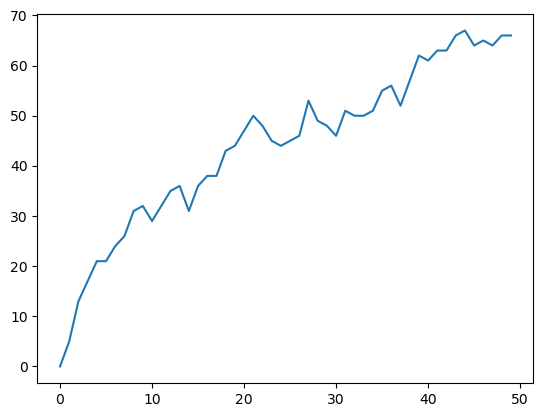

In [9]:
times = np.linspace(0, 80)

def simulate(theta):
    R01, k10, k12, k21 = theta
    num_times = len(times)
    times_array = (ctypes.c_double * num_times)(*times)
    answer_array = gillespie_lib.run_prc1_sim(R01, k12, k10, k21, times_array, num_times)
    # answer_array = gillespie_lib.run_prc1_sim(ctypes.c_double(R01), ctypes.c_double(k12), ctypes.c_double(k10), ctypes.c_double(k21),
                                              # times_array, ctypes.c_int(num_times))
    return answer_array[:num_times]

plt.plot(simulate( (2.83723976, 3.19827888, 620.3984088, 2.45246624) ))

In [6]:
def prior_density(theta):
    R01, k10, k12, k21 = theta
    p1 = expon.logpdf(R01, scale=10)  # rate = 0.1
    p2 = expon.logpdf(k10, scale=10)
    p3 = truncnorm.logpdf(k12, a=(0-800)/400, b=np.inf, loc=800, scale=400) 
    p4 = expon.logpdf(k21, scale=10)
    return np.exp(p1 + p2 + p3 + p4)

def kernel_density(x, mean, cov):
    return multivariate_normal.pdf(x, mean=mean, cov=cov)
    
def sequential_abc(num_generations, num_particles, sample_size, obs_summary):
    epsilon_0, particles, weights, distances = pilot_run(
        sample_size=sample_size,
        num_particles=num_particles,
        obs_summary=obs_summary
    )
    epsilon_list = [epsilon_0]

    kernel_cov = np.cov(particles.T) + 1e-5 * np.eye(particles.shape[1])  # regularization, we need this just for the weight function 

    for t in range(1, num_generations):
        epsilon_t = np.percentile(distances, 50)  #new threshold, currently setting at median
        epsilon_list.append(epsilon_t)

        new_particles = []
        new_weights = []
        new_distances = []
        while len(new_particles) < num_particles:
            # resample from previous particles
            idx = np.random.choice(len(particles), p=weights)
            theta_prev = particles[idx]

            theta_prop = theta_prev + np.random.multivariate_normal(np.zeros(len(theta_prev)), kernel_cov)

            #simulate with proposed theta
            sim_data = simulate(theta_prop) #again, this is the now run the simulate function
            sim_mean = np.mean(sim_data[:, 0])
            sim_sd = np.mean(sim_data[:, 1])
            sim_summary = np.array([sim_mean, sim_sd])
            d = np.linalg.norm(sim_summary - obs_summary)

            # Accept if within epsilon
            if d <= epsilon_t:
                prior_val = prior_density(theta_prop)

                denom = 0.0
                for j in range(len(particles)):
                    denom += weights[j] * kernel_density(theta_prop, mean=particles[j], cov=kernel_cov)
                    #this is from the paper 

                weight = prior_val / denom
                new_particles.append(theta_prop)
                new_weights.append(weight)
                new_distances.append(d)

        # normalize 
        new_weights = np.array(new_weights)
        new_weights /= np.sum(new_weights)

        particles = np.array(new_particles)
        weights = new_weights
        distances = np.array(new_distances)

    return particles, weights, epsilon_list